# Introduction to Text as Data

## UNM Workshop, April 9, 2018

(following steps adapted from Wilson (2017)authoring guidelines)

### Brainstorm

1. What problem(s) will students learn how to solve?
    - How to load text data into R tidyverse
    - How to begin exploring a text dataset
    - How to extract unigrams, bigrams
    - How to find most popular terms
    - How to perform topic modeling, probably with structural topic modeling
2. What techniques or concepts will students learn?
    - Piping data
    - Stopwords
    - Tokenization
3. What technologies, packages, or functions will students use?
    - `dplyr`
    - `ggplot2`
    - `tidytext`
    - `stm`
4. What terms or jargon will you define?
    - tidy
    - tidytext
5. What analogies or heuristics will you use?
    - Tidy is a grammar
    - actions are verbs
6. What mistakes or misconceptions do you expect?
    - What a topic is
    - What form data takes as the output of each verb
7. What datasets will you use?
    - Congressional floor speeches?
    - Look at what Grimmer has used
    - Congressional press releases

### What will students learn along the way?

#### 1. Counting most popular words with `tidytext`

In [21]:
library(tidytext)
library(gutenbergr)

In [16]:
## A Vindication of the Rights of Woman by Mary Wollstonecraft
vindication <- gutenberg_download(3420)

Determining mirror for Project Gutenberg from http://www.gutenberg.org/robot/harvest
Using mirror http://aleph.gutenberg.org


In [30]:
tidy_vindication <- vindication %>% 
    unnest_tokens(word, text)

tidy_vindication %>%
    anti_join(stop_words) %>%
    count(word, sort = TRUE) %>%
    top_n(10)

Joining, by = "word"
Selecting by n


word,n
women,445
reason,264
mind,232
virtue,198
woman,190
love,173
life,170
nature,147
character,144
respect,133


#### 2. Graphing the prevalence of words in two texts

In [7]:
library(dplyr)
library(tidytext)
library(gutenbergr)
library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [8]:
## A Vindication of the Rights of Woman by Mary Wollstonecraft
vindication <- gutenberg_download(3420)

## The Subjection of Women by John Stuart Mill
subjection <- gutenberg_download(27083)

In [36]:
tidy_subjection <- subjection %>% 
    unnest_tokens(word, text) %>%
    anti_join(stop_words) %>%
    count(word) %>% 
    mutate(proportion = n / sum(n)) %>%
    top_n(10)

tidy_vindication <- vindication %>% 
    unnest_tokens(word, text) %>%
    anti_join(stop_words) %>%
    count(word) %>% 
    mutate(proportion = n / sum(n)) %>%
    arrange(-proportion) %>%
    top_n(10)

Joining, by = "word"
Selecting by proportion
Joining, by = "word"
Selecting by proportion


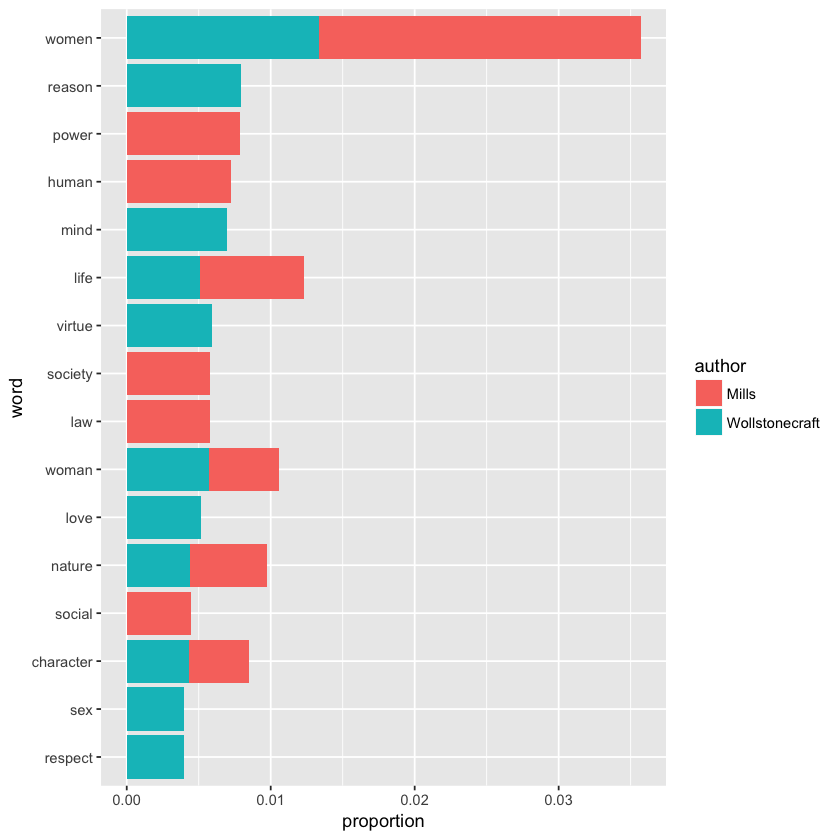

In [39]:
tidy_books <- bind_rows(mutate(tidy_subjection, author = 'Mills'), 
                        mutate(tidy_vindication, author = 'Wollstonecraft'))
tidy_books %>% mutate(word = reorder(word, proportion)) %>% 
    ggplot(aes(word, proportion, fill = author)) + 
    geom_col() + 
    coord_flip()

#### 3. Generating structured topic models from a corpus

### Step 4: How are the concepts connected?